In [1]:
#La librairie Pandas fournit deux structures de données fondamentales, la "Series" et le "DataFrame". On peut voir ces structures comme une généralisation des tableaux et des matrices de Numpy. La différence fondamentale entre ces structures et les versions de Numpy est que les objets Pandas possèdent des indices explicites. Là où on ne pouvait se référer à un élément d'un tableau Numpy que par sa position dans le tableau, chaque élément d'une Series ou d'un DataFrame peut avoir un indice explicitement désigné par l'utilisateur.
import pandas as pd
#import time
#import os
#import csv
from numpy import array
import numpy as np
#use findSpark package to make a Spark Context available in your code.
import findspark
findspark.init()

from pyspark.sql import SQLContext 
from pyspark import SparkContext
sqlContext = SQLContext(sc)

from pyspark import SparkConf
conf = SparkConf()


In [2]:
data = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('hdfs://spark1VM:9000/data/data.csv')
data.cache()


DataFrame[_c0: int, recordnum: int, cardnum: bigint, date: timestamp, merchnum: string, merch.description: string, merch.state: string, merch.zip: string, transtype: string, amount: double, fraud: string, card_amount_to_avg_3: double, card_amount_to_max_3: double, card_amount_to_median_3: double, card_amount_to_total_3: double, merchant_amount_to_avg_3: double, merchant_amount_to_max_3: double, merchant_amount_to_median_3: double, merchant_amount_to_total_3: double, card_amount_to_avg_7: double, card_amount_to_max_7: double, card_amount_to_median_7: double, card_amount_to_total_7: double, merchant_amount_to_avg_7: double, merchant_amount_to_max_7: double, merchant_amount_to_median_7: double, merchant_amount_to_total_7: double, card_amount_to_avg_14: double, card_amount_to_max_14: double, card_amount_to_median_14: double, card_amount_to_total_14: double, merchant_amount_to_avg_14: double, merchant_amount_to_max_14: double, merchant_amount_to_median_14: double, merchant_amount_to_total_1

In [3]:
df=data.filter(data.date > '2010-01-28')
df=df.select(df.columns[10:])
df=df.fillna(0)
df=df.na.replace(['NA'],['0'],'fraud')
dfp=df.toPandas()
dfp.fraud.describe()



count     88914
unique        2
top           0
freq      88619
Name: fraud, dtype: object

In [4]:
featuresName=dfp.columns


In [5]:
#https://dataplatform.ibm.com/analytics/notebooks/89492fd6-a641-4819-9176-3d9381561df9/view?access_token=d80bef1a172d1d83d3721b101886337158457281774186f181a2e6a5b57f5ec7
from pyspark.ml.feature import StringIndexer,VectorIndexer,VectorAssembler
#from pyspark.sql.types import *
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.

label = StringIndexer(inputCol=df.columns[0], outputCol="label").fit(df)
df_label_features=label.transform(df)
labelIndexer = StringIndexer(inputCol=df.columns[0], outputCol="indexedLabel").fit(df_label_features)


features = VectorAssembler(inputCols=df.columns[1:], outputCol="vectorAssembler_features")
df_label_features=features.transform(df_label_features)
featureIndexer =VectorIndexer(inputCol="vectorAssembler_features", outputCol="indexedFeatures").fit(df_label_features)

In [6]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="vectorAssembler_features", outputCol="features",withStd=True, withMean=False)
# Compute summary statistics by fitting the StandardScaler

scalerModel = scaler.fit(df_label_features)

# Normalize each feature to have unit standard deviation.
df_label_features = scalerModel.transform(df_label_features)

In [7]:
from pyspark.ml.feature import Normalizer

# Normalize each Vector using $L^1$ norm.
normalizer = Normalizer(inputCol="features", outputCol="gbt_features", p=1.0)
df_label_features = normalizer.transform(df_label_features)



In [ ]:
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df_label_features)

result = model.transform(df_label_features).select("pcaFeatures","label")


#result.show(truncate=False)

true_label=result.filter(result.label==1.0).select("pcaFeatures").rdd.map(lambda row: [row[0][0], row[0][1]]).collect()
true_label = np.array(true_label)
x_red=np.array(zip(*true_label)[0])
y_red=np.array(zip(*true_label)[1])


false_label=result.filter(result.label==0.0).select("pcaFeatures").rdd.map(lambda row: [row[0][0], row[0][1]]).collect()
false_label = np.array(false_label)
x_blue=np.array(zip(*false_label)[0])
y_blue=np.array(zip(*false_label)[1])


In [ ]:

#plt.subplot(121)
from matplotlib import pyplot as plt


%matplotlib inline
plt.rcParams["font.size"] =20

plt.scatter(x_blue,y_blue, label='False fraud %0.0f'%x_blue.size, c='blue')
#plt.subplot(122)
plt.scatter(x_red,y_red, label='True fraud %0.0f'%x_red.size, c='red',marker='^',s=200)
#tt=true_label.toPandas().values
#aa=np.array(tt)
#aa
#import matplotlib.pyplot as plt
#plt.scatter(false_label,false_label, label='Class 2', c='blue')

plt.legend(loc="lower right")
plt.gcf().set_size_inches((30,50))   
#plt.plot([-100, 50], [-100, 50], color = 'red', linestyle = 'solid') 

plt.show()

In [ ]:
#https://matplotlib.org/gallery/event_handling/zoom_window.html

figzoom, axzoom = plt.subplots()

axzoom.set(xlim=(-13.5,21.5), ylim=(-20.2,0.1), autoscale_on=False,
           title='zoom')

axzoom.scatter(x_blue,y_blue, label='False fraud %0.0f'%x_blue.size, c='blue')
axzoom.scatter(x_red,y_red, label='True fraud %0.0f'%x_red.size, c='red',marker='^',s=200)
plt.rcParams["font.size"] =20
plt.legend(loc="lower right")
plt.gcf().set_size_inches((30,50))   
plt.show()

In [ ]:

RANDOM_SEED = 13579
TRAINING_DATA_RATIO = 0.77
splits = [TRAINING_DATA_RATIO, 1.0 - TRAINING_DATA_RATIO]
training_data, test_data = df_label_features.randomSplit(splits, RANDOM_SEED)



In [ ]:
training_data.cache()
nombre_training=training_data.count()

print("Number of training set rows: %d" % nombre_training)
nombre_fraude_in_training=training_data.filter(training_data.fraud==1).count()
print("Number of fraud in training: %d" % nombre_fraude_in_training)
print("Taux  fraud in test: %.2f " % ((float(nombre_fraude_in_training)/nombre_training)*100))

nombre_test=test_data.count()
print("Number of test set rows: %d" % nombre_test)
nombre_fraude_in_test=test_data.filter(test_data.fraud==1).count()
print("Number of fraud  in test: %d" % nombre_fraude_in_test)
print("Taux  fraud in test: %.2f " % ((float(nombre_fraude_in_test)/nombre_test)*100))


In [ ]:
#https://weiminwang.blog/2016/06/09/pyspark-tutorial-building-a-random-forest-binary-classifier-on-unbalanced-dataset/
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html 
from sklearn.metrics import roc_curve, auc,precision_recall_curve,average_precision_score,recall_score

def resultat_curve(train_model,train_model2=None):
    
    

    ## prepare score-label set
  
    if train_model2 is not None :
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        result2 = train_model2.transform(test_data)    
        results2 = result2.select(['probability', 'label'])    
        results_collect2 = results2.collect()
        results_list2 = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect2]       
        y_test2 = [i[1] for i in results_list2]
        y_score2 = [i[0] for i in results_list2]    
        fpr2, tpr2, _ = roc_curve(y_test2, y_score2)
        roc_auc2 = auc(fpr2, tpr2)
        plt.plot(fpr2, tpr2,label='Avant ROC curve (area = %0.2f)' % roc_auc2, alpha=0.5,
                         color='g')
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    result = train_model.transform(test_data)    
    results = result.select(['probability', 'label'])    
    results_collect = results.collect()
    results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]       
    y_test = [i[1] for i in results_list]
    y_score = [i[0] for i in results_list]    
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,label='Apres ROC curve (area = %0.2f)' % roc_auc, alpha=0.5,
                     color='b')
    #AUC PR  
    plt.plot([1, 0], [1, 0], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    if train_model2 is not None :
        results_list2 = [(1.0-float(i[0][0]),float(i[1])) for i in results_collect2]       
        y_test2 = [i[1] for i in results_list2]
        y_score2 = [round(i[0]) for i in results_list2]
        average_precision2 = average_precision_score(y_test2, y_score2)
        average_recall2 = recall_score(y_test2, y_score2)  
        precision2, recall2, _ = precision_recall_curve(y_test2, y_score2)
        plt.plot(recall2, precision2,label='Avant AP= %0.2f'%
          average_precision2+', AR= %0.2f'%
          average_recall2, alpha=0.5,
                         color='g')

        
            
    results_list = [(1.0-float(i[0][0]),float(i[1])) for i in results_collect]       
    y_test = [i[1] for i in results_list]
    y_score = [round(i[0]) for i in results_list]
    average_precision = average_precision_score(y_test, y_score)
    average_recall = recall_score(y_test, y_score)  
    precision, recall, _ = precision_recall_curve(y_test, y_score)

  
    #plt.subplot(212)
    plt.plot(recall, precision,label='Apres AP=%0.2f'%
          average_precision+', AR= %0.2f'%
          average_recall, alpha=0.2,
                     color='b')

    plt.plot([1, 0], [0, 1], 'k--')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('2-class Precision-Recall curve')  
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [ ]:
from time import *
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric

def test_comparison(train_model):
    #train data
    
    start_time = time()    
    result = train_model.transform(training_data)    
    multiClassEvaluator=MulticlassClassificationEvaluator()  
    train_acc= multiClassEvaluator.evaluate(result,{multiClassEvaluator.metricName: "accuracy"})        
    evaluator = BinaryClassificationEvaluator()
    train_areaUnderPR= evaluator.evaluate(result,{evaluator.metricName: "areaUnderPR"})
    train_areaUnderROC= evaluator.evaluate(result,{evaluator.metricName: "areaUnderROC"}) 
    #https://www.linkedin.com/pulse/get-your-hands-on-pyspark-solve-kaggle-problems-majid-bahrepour-phd
    train_tp = float(result.filter("prediction == 1.0 AND label==1").count())
    train_tn = float(result.filter("prediction == 0.0 AND label==0").count())
    train_fp = float(result.filter("prediction == 1.0 AND label==0").count())
    train_fn = float(result.filter("prediction == 0.0 AND label==1").count())
    train_percision=train_tp/(train_tp+train_fp)
    train_recall=train_tp/(train_tp+train_fn)
    end_time = time()
    train_time = end_time - start_time

    #Test data
    start_time = time()
    result = train_model.transform(test_data)
    evaluator = BinaryClassificationEvaluator()              
    multiClassEvaluator=MulticlassClassificationEvaluator()        
    test_acc= multiClassEvaluator.evaluate(result,{multiClassEvaluator.metricName: "accuracy"})        
    test_areaUnderPR= evaluator.evaluate(result,{evaluator.metricName: "areaUnderPR"})
    test_areaUnderROC= evaluator.evaluate(result,{evaluator.metricName: "areaUnderROC"}) 
    test_tp = float(result.filter("prediction == 1.0 AND label==1").count())
    test_tn = float(result.filter("prediction == 0.0 AND label==0").count())
    test_fp = float(result.filter("prediction == 1.0 AND label==0").count())
    test_fn = float(result.filter("prediction == 0.0 AND label==1").count())
    test_percision=test_tp/(test_tp+test_fp)
    test_recall=test_tp/(test_tp+test_fn)
    end_time = time()
    test_time = end_time - start_time
    
    return np.array([["%.3f" % (train_acc),"%.3f" % (test_acc),"%.3f" % (train_areaUnderPR),"%.3f" % (test_areaUnderPR),"%.3f" % (train_areaUnderROC),"%.3f" % (test_areaUnderROC),"%.3f" % (train_recall),"%.3f" % (test_recall),train_percision,test_percision,"%.3f seconds" % (train_time),"%.3f seconds" % (test_time)]])

In [ ]:
from pyspark.ml.classification import  RandomForestClassifier
start_time = time()

rf = RandomForestClassifier()
train_model_simple = rf.fit(training_data)
end_time = time()
model_train_time_simple = end_time - start_time
print("Time to train RandomForestClassifier model : %.3f seconds" % model_train_time_simple)
model_train_time_simple ="%.3f seconds" % model_train_time_simple
rf.explainParams()

In [ ]:
#https://blog.epigno.systems/2018/02/24/machine-learning-with-pyspark-feature-ranking/
#machine-learning-with-pyspark-feature-ranking

bestParams = train_model_simple.extractParamMap()
model = pd.DataFrame(train_model_simple.featureImportances.toArray(), columns=["values"])

model["features"] = featuresName[1:]  
model

In [ ]:

plt.bar(range(1,len(model)+1), model["values"])
plt.title("Feature Ranking")
plt.xlabel("Feature Number")
plt.ylabel("Ranking")

In [ ]:
print len(np.array(range(len(model)))[model["values"] > 0.02])
print len(np.array(range(len(model)))[model["values"] > 0.03])
print len(np.array(range(len(model)))[model["values"] > 0.04])

In [ ]:
dfp.columns.values[[i+1 for i in np.array(range(len(model)))[model["values"] > 0.04]]]

In [ ]:
model["values"][np.array(range(len(model)))[model["values"] > 0.04]]

In [ ]:

dataMesure = np.array([['Model','Time to train model','Training Accuracy','Testing Accuracy','Training (areaUnderPR)','Testing (areaUnderPR)','Training (areaUnderROC)','Testing (areaUnderROC)','Training Recall','Testing Recall','Training Percision','Testing Percision','Time to valuate training model','Time to valuate test model'],])


row=np.append([['The simplest Random Forest']],[[model_train_time_simple]],axis=1)
row=np.append(row,test_comparison(train_model_simple), axis=1)
dataMesure = np.append(dataMesure,row, axis=0)

pd.DataFrame(data=dataMesure[1:,1:],
                  index=dataMesure[1:,0],
                  columns=dataMesure[0,1:])


In [ ]:
df_label_features.groupby('label').count().toPandas()

In [ ]:
stratified_df_label_features = df_label_features.sampleBy('label', fractions={0: 295./88619, 1: 1.0}).cache()
stratified_df_label_features.groupby('label').count().toPandas()



In [ ]:

RANDOM_SEED = 13579
TRAINING_DATA_RATIO = 0.77
splits = [TRAINING_DATA_RATIO, 1.0 - TRAINING_DATA_RATIO]
training_data, test_data = stratified_df_label_features.randomSplit(splits, RANDOM_SEED)



In [ ]:
training_data.cache()
nombre_training=training_data.count()

print("Number of training set rows: %d" % nombre_training)
nombre_fraude_in_training=training_data.filter(training_data.fraud==1).count()
print("Number of fraud in training: %d" % nombre_fraude_in_training)
print("Taux  fraud in test: %.2f " % ((float(nombre_fraude_in_training)/nombre_training)*100))

nombre_test=test_data.count()
print("Number of test set rows: %d" % nombre_test)
nombre_fraude_in_test=test_data.filter(test_data.fraud==1).count()
print("Number of fraud  in test: %d" % nombre_fraude_in_test)
print("Taux  fraud in test: %.2f " % ((float(nombre_fraude_in_test)/nombre_test)*100))


In [ ]:

start_time = time()

rf = RandomForestClassifier()
train_model = rf.fit(training_data)
end_time = time()
model_train_time = end_time - start_time
print("Time to train RandomForestClassifier model : %.3f seconds" % model_train_time)
model_train_time ="%.3f seconds" % model_train_time


In [ ]:

dataMesure = np.array([['Model','Time to train model','Training Accuracy','Testing Accuracy','Training (areaUnderPR)','Testing (areaUnderPR)','Training (areaUnderROC)','Testing (areaUnderROC)','Training Recall','Testing Recall','Training Percision','Testing Percision','Time to valuate training model','Time to valuate test model'],])


row=np.append([['The best Random Forest']],[[model_train_time]],axis=1)
row=np.append(row,test_comparison(train_model), axis=1)
dataMesure = np.append(dataMesure,row, axis=0)

row=np.append([['The simplest Random Forest']],[[model_train_time_simple]],axis=1)
row=np.append(row,test_comparison(train_model_simple), axis=1)
dataMesure = np.append(dataMesure,row, axis=0)

pd.DataFrame(data=dataMesure[1:,1:],
                  index=dataMesure[1:,0],
                  columns=dataMesure[0,1:])


In [ ]:
plt.rcParams["font.size"] =10
resultat_curve(train_model,train_model_simple)

Total run time is 179.38 sec. Current max bins is 2
Total run time is 166.76 sec. Current max bins is 4
Total run time is 166.72 sec. Current max bins is 6
Total run time is 164.46 sec. Current max bins is 8
Total run time is 169.80 sec. Current max bins is 10
Total run time is 170.17 sec. Current max bins is 12
Total run time is 170.00 sec. Current max bins is 14
Total run time is 179.85 sec. Current max bins is 16
Total run time is 174.40 sec. Current max bins is 18
Total run time is 181.06 sec. Current max bins is 20
Total run time is 182.74 sec. Current max bins is 22
Total run time is 182.74 sec. Current max bins is 24
Total run time is 188.11 sec. Current max bins is 26
Total run time is 188.47 sec. Current max bins is 28
Total run time is 193.25 sec. Current max bins is 30
The optimal number of max bins is 10 with 97.8%


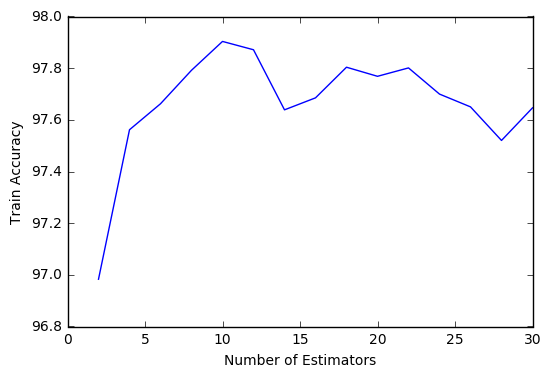

In [30]:
#http://r-train.ru/binary-classification-in-spark/
from collections import OrderedDict
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Range of `n_estimators` values to explore.
n_bins = filter(lambda x: x % 2 == 0, list(range(2,32)))
 
cv_scores = []
 
for i in n_bins:
    start = time()
    rf = RandomForestClassifier(numTrees = 500,maxDepth=10,seed=12345L,impurity="entropy",featureSubsetStrategy="auto",minInstancesPerNode=1)
    pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])
    paramGrid = ParamGridBuilder().addGrid(rf.maxBins,[i]).build()
    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(metricName='areaUnderPR'),
                          numFolds=10,seed=12345L)
    train_model = crossval.fit(training_data)    
    cv_scores.append(train_model.avgMetrics[0]*100)
    print('Total run time is {:0.2f} sec. Current max bins is {}'.format(time() - start, i))
optimal_n_bins = n_bins[cv_scores.index(max(cv_scores))]
print "The optimal number of max bins is %d with %0.001f%%" % (optimal_n_bins, cv_scores[optimal_n_bins])
 
plt.plot(n_bins, cv_scores)
plt.xlabel('Number of Estimators')
plt.ylabel('Train Accuracy')
plt.show()    

In [33]:
#http://r-train.ru/binary-classification-in-spark/
from collections import OrderedDict
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Range of `n_estimators` values to explore.
n_trees = filter(lambda x: x % 50 == 0, list(range(400,1000)))
 
cv_scores = []
 
for i in n_trees:
    start = time()
    rf = RandomForestClassifier(maxBins=10 ,maxDepth=10,seed=12345L,impurity="entropy",featureSubsetStrategy="auto",minInstancesPerNode=1)
    pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])
    paramGrid = ParamGridBuilder().addGrid(rf.numTrees,[i]).build()
    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(metricName='areaUnderPR'),
                          numFolds=10,seed=12345L) 
    train_model = crossval.fit(training_data)
    
    cv_scores.append(train_model.avgMetrics[0]*100)
    print('Total run time is {:0.2f} sec. Current max number trees is {}'.format(time() - start, i))
optimal_n_trees = n_trees[cv_scores.index(max(cv_scores))]
print "The optimal number of max number trees is %d with %0.001f%%" % (optimal_n_trees, cv_scores[optimal_n_trees])
 
plt.plot(n_bins, cv_scores)
plt.xlabel('Number of trees')
plt.ylabel('Train Accuracy')
plt.show()    

Total run time is 102.52 sec. Current max number trees is 400
Total run time is 124.61 sec. Current max number trees is 450
Total run time is 139.88 sec. Current max number trees is 500
Total run time is 151.31 sec. Current max number trees is 550
Total run time is 162.82 sec. Current max number trees is 600
Total run time is 175.94 sec. Current max number trees is 650
Total run time is 188.15 sec. Current max number trees is 700
Total run time is 188.17 sec. Current max number trees is 750
Total run time is 198.64 sec. Current max number trees is 800
Total run time is 205.77 sec. Current max number trees is 850
Total run time is 215.64 sec. Current max number trees is 900
Total run time is 227.25 sec. Current max number trees is 950


IndexError: list index out of range

In [1]:
optimal_n_trees = n_trees[cv_scores.index(max(cv_scores))]
print "The optimal number of max number trees is %d with %0.001f%%" % (optimal_n_trees, cv_scores[optimal_n_trees])
 
plt.plot(n_bins, cv_scores)
plt.xlabel('Number of trees')
plt.ylabel('Train Accuracy')
plt.show()

NameError: name 'n_trees' is not defined

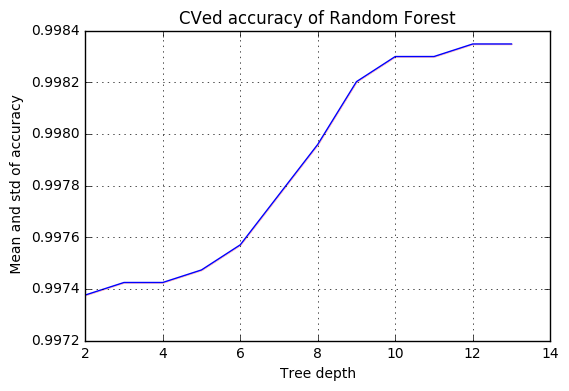

In [26]:
depth = np.array([d for d in acc_depth])
mn = np.array([i[1][0] for i in acc_depth.items()])
sd = np.array([i[1][1] for i in acc_depth.items()])

plt.plot(depth, mn)
plt.fill_between(depth, mn + sd, mn -sd, color='r', alpha = .2)
plt.title('CVed accuracy of Random Forest')
plt.xlabel('Tree depth')
plt.ylabel(' Mean and std of accuracy')
plt.grid();

In [ ]:
print pr_vector


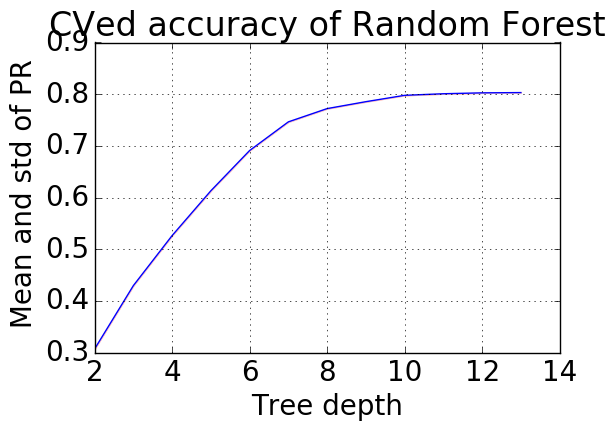

In [21]:
depth = np.array([d for d in pr_depth])
mn = np.array([i[1][0] for i in pr_depth.items()])
sd = np.array([i[1][1] for i in pr_depth.items()])

plt.plot(depth, mn)
plt.fill_between(depth, mn + sd, mn -sd, color='r', alpha = .2)
plt.title('CVed PR of Random Forest')
plt.xlabel('Tree depth')
plt.ylabel(' Mean and std of PR')
plt.grid();